In [1]:
from scipy.stats import multivariate_normal
from LabelRanking import *
import pickle
from mallows import MallowsModel
from tqdm import tqdm

In [2]:
d = 10  # data dimension
k = 5  # labels

# Feature vectors distribution
D = multivariate_normal(mean=np.zeros(d), cov=np.identity(d))

# Linear Sorting Function
W = np.random.rand(k, d)

with open('trained models/mallows/W.pickle', 'wb') as handle: pickle.dump(W, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Train data
X_train = D.rvs(size=1000)

R_train = LinearSortingFunction(X_train, W)
P_train = np.argsort(R_train, axis=1)

##### Train models using data with RCN

In [3]:
thetas = np.arange(0, 4.1, 0.2)

LABELWISE_LR = {} # Linear Regression
LABELWISE_DT = {} # Decision Tree Regression
LABELWISE_RF = {} # Random Forest Regression
PAIRWISE_HH = {} # Homogeneous Halfspace Classification
PAIRWISE_DT = {} # Decision Tree Classification
PAIRWISE_RF = {} # Random Forest Classification

for theta in tqdm(thetas):
  mallows = MallowsModel(k, theta)
  P_train_noisy = np.array([mallows.sample(y) for y in P_train])

  LABELWISE_LR[theta] = LabelwiseLabelRanking('Linear', dict(n_jobs=-1)).fit(X_train, P_train_noisy)
  LABELWISE_DT[theta] = LabelwiseLabelRanking('Decision Tree', dict(criterion='squared_error', max_features=None)).fit(X_train, P_train_noisy)
  LABELWISE_RF[theta] = LabelwiseLabelRanking('Random Forest', dict(n_estimators=200, max_features='log2', n_jobs=-1)).fit(X_train, P_train_noisy)

  PAIRWISE_HH[theta] = PairwiseLabelRanking('Homogeneous Halfspace', dict(beta=0.005, sigma=0.1), aggregation='tournament').fit(X_train, P_train_noisy)
  PAIRWISE_DT[theta] = PairwiseLabelRanking('Decision Tree', dict(criterion='gini', max_features=None), aggregation='tournament').fit(X_train, P_train_noisy)
  PAIRWISE_RF[theta] = PairwiseLabelRanking('Random Forest', dict(n_estimators=200, max_features='log2', n_jobs=-1), aggregation='tournament').fit(X_train, P_train_noisy)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [10:48<00:00, 30.87s/it]


##### Save trained models and ground truth LSF

In [4]:
with open('trained models/mallows/LABELWISE_LR.pickle', 'wb') as handle: pickle.dump(LABELWISE_LR, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/mallows/LABELWISE_DT.pickle', 'wb') as handle: pickle.dump(LABELWISE_DT, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/mallows/LABELWISE_RF.pickle', 'wb') as handle: pickle.dump(LABELWISE_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/mallows/PAIRWISE_HH.pickle', 'wb') as handle: pickle.dump(PAIRWISE_HH, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/mallows/PAIRWISE_DT.pickle', 'wb') as handle: pickle.dump(PAIRWISE_DT, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/mallows/PAIRWISE_RF.pickle', 'wb') as handle: pickle.dump(PAIRWISE_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Load trained models and ground truth LSF

In [5]:
with open('trained models/mallows/LABELWISE_LR.pickle', 'rb') as handle: LABELWISE_LR = pickle.load(handle)
with open('trained models/mallows/LABELWISE_DT.pickle', 'rb') as handle: LABELWISE_DT = pickle.load(handle)
with open('trained models/mallows/LABELWISE_RF.pickle', 'rb') as handle: LABELWISE_RF = pickle.load(handle)
with open('trained models/mallows/PAIRWISE_HH.pickle', 'rb') as handle: PAIRWISE_HH = pickle.load(handle)
with open('trained models/mallows/PAIRWISE_DT.pickle', 'rb') as handle: PAIRWISE_DT = pickle.load(handle)
with open('trained models/mallows/PAIRWISE_RF.pickle', 'rb') as handle: PAIRWISE_RF = pickle.load(handle)

with open('trained models/mallows/W.pickle', 'rb') as handle: W = pickle.load(handle)

thetas = np.array(list(LABELWISE_LR.keys()))

##### Create test data

In [6]:
X_test = D.rvs(size=1000)
R_test = LinearSortingFunction(X_test, W)
P_test = np.argsort(R_test, axis=1)

##### Predict rankings for all classifiers and etas

In [7]:
LABELWISE_LR_preds = {eta: LABELWISE_LR[eta].predict(X_test) for eta in thetas}
LABELWISE_DT_preds = {eta: LABELWISE_DT[eta].predict(X_test) for eta in thetas}
LABELWISE_RF_preds = {eta: LABELWISE_RF[eta].predict(X_test) for eta in thetas}
PAIRWISE_HH_preds = {eta: PAIRWISE_HH[eta].predict(X_test) for eta in thetas}
PAIRWISE_DT_preds = {eta: PAIRWISE_DT[eta].predict(X_test) for eta in thetas}
PAIRWISE_RF_preds = {eta: PAIRWISE_RF[eta].predict(X_test) for eta in thetas}

##### Find scores for all classifiers and etas

In [8]:
LABELWISE_LR_KT_corr = {eta: mean_KTcorrelation(P_test, LABELWISE_LR_preds[eta]) for eta in thetas}
LABELWISE_DT_KT_corr = {eta: mean_KTcorrelation(P_test, LABELWISE_DT_preds[eta]) for eta in thetas}
LABELWISE_RF_KT_corr = {eta: mean_KTcorrelation(P_test, LABELWISE_RF_preds[eta]) for eta in thetas}
PAIRWISE_HH_KT_corr = {eta: mean_KTcorrelation(P_test, PAIRWISE_HH_preds[eta]) for eta in thetas}
PAIRWISE_DT_KT_corr = {eta: mean_KTcorrelation(P_test, PAIRWISE_DT_preds[eta]) for eta in thetas}
PAIRWISE_RF_KT_corr = {eta: mean_KTcorrelation(P_test, PAIRWISE_RF_preds[eta]) for eta in thetas}

##### Plot scores for all classifiers and etas

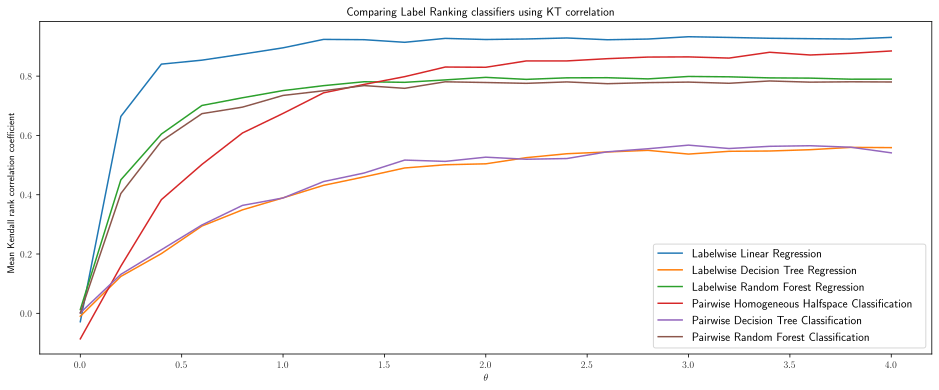

In [9]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

plt.rcParams['text.usetex'] = True

plt.figure(figsize=(16, 6))
plt.title('Comparing Label Ranking classifiers using KT correlation')
plt.plot(thetas, LABELWISE_LR_KT_corr.values())
plt.plot(thetas, LABELWISE_DT_KT_corr.values())
plt.plot(thetas, LABELWISE_RF_KT_corr.values())
plt.plot(thetas, PAIRWISE_HH_KT_corr.values())
plt.plot(thetas, PAIRWISE_DT_KT_corr.values())
plt.plot(thetas, PAIRWISE_RF_KT_corr.values())
plt.legend([
  'Labelwise Linear Regression',
  'Labelwise Decision Tree Regression',
  'Labelwise Random Forest Regression',
  'Pairwise Homogeneous Halfspace Classification',
  'Pairwise Decision Tree Classification',
  'Pairwise Random Forest Classification',
  ], 
  fontsize=12
)
plt.xlabel(r"$\theta$")
plt.ylabel('Mean Kendall rank correlation coefficient')
plt.show()